In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

In [10]:
def non_max_suppression_fast(boxes, overlapThresh,probs):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the scores
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list

    final_boxes = []
    while len(idxs) > 0:

        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))

        # return only the bounding boxes that were picked using the
        # integer data type
        #eturn boxes[pick].astype("int")
        final_boxes.append(boxes[pick])
        #print(boxes[pick])
    return boxes[pick]


In [12]:
ROI_number = 0

In [13]:
def extract_plate(image, base_model_name):
    
#     load the model
    model = load_model(base_model_name)
    
#     Perform Selective Search for the given image and then passes each region through the CNN.
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    results = ss.process()
    copy = image.copy()
    copy2 = image.copy()
    positive_boxes = []
    probs = []

#     extract the x, y, w, h co ordinates of the bounding box of the region
    for box in results:
        x1 = box[0]
        y1 = box[1]
        x2 = box[0] + box[2]
        y2 = box[1] + box[3]

#     obtain the region of interest with these co ordinates and resize, reshape it
        roi = image.copy()[y1:y2, x1:x2]
        roi = cv2.resize(roi, (128, 128))
        roi_use = roi.reshape((1, 128, 128, 3))
        
#     predict the class of extracted roi as plate or not_plate
        class_pred = model.predict_classes(roi_use)[0][0]

        if class_pred == 1:   # if predicted class is plate
            prob = model.predict(roi_use)[0][0]
            if prob > 0.98:   # CNN predicts with more than 98% confidence that region has number plate
                positive_boxes.append([x1, y1, x2, y2])
                probs.append(prob)
                cv2.rectangle(copy2, (x1, y1), (x2, y2), (255, 0, 0), 1)
                

#     selecting the required and accurate box among all
#     selecting a single entity out of many overlapping entities using non_max_suppression_fast 
    cleaned_boxes = non_max_suppression_fast(np.array(positive_boxes), 0.1, probs)
    total_boxes = 0
    for clean_box in cleaned_boxes:
        clean_x1 = clean_box[0]
        clean_y1 = clean_box[1]
        clean_x2 = clean_box[2]
        clean_y2 = clean_box[3]
        total_boxes += 1
        cv2.rectangle(copy, (clean_x1, clean_y1), (clean_x2, clean_y2), (0, 255, 0), 3)
        
#     Extract the detected plate as an image
        ROI = image[clean_y1:clean_y1+clean_y2-clean_y1, clean_x1:clean_x1+clean_x2-clean_x1]    
        cv2.imwrite('ROI.png', ROI)
        
#         ROI_resize = cv2.resize(ROI, (200,200))

#         sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
#         sharpen = cv2.filter2D(ROI, -1, sharpen_kernel)
        
#         cv2.imwrite('ROI_{}.png'.format(ROI_number), sharpen)
#         ROI_number += 1
#         cv2.imshow('sharpen', sharpen)
#         cv2.imwrite('ROI.png', ROI)

#     plt.imshow(copy2)

#     plt.imshow(ROI_resize)
#     img_roi = cv2.imread('ROI.png')

#     show the detected plate
    plt.imshow(ROI)

    plt.show()

In [14]:
# funtion that extracts the number plate from given image
def image(image_name, model_name):
    test_img = cv2.imread(image_name)
    extract_plate(test_img, model_name)

In [15]:
image('1.jpg','base_model.h5')

OSError: SavedModel file does not exist at: base_model.h5\{saved_model.pbtxt|saved_model.pb}

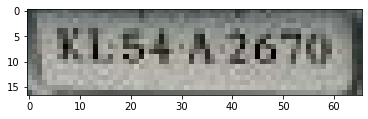

In [10]:
image('2.jpg','base_model.h5')

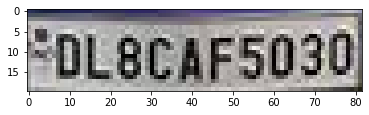

In [13]:
image('3.jpg','base_model.h5')